In [1]:
import random
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import statistics

In [2]:
class TicTacToe:
    def __init__(self):
        self.board = []
        self.moves = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]

    """
      Set all board entries to -1
    """
    def reset(self):
      self.board = []
      for i in range(3):
          row = []
          for j in range(3):
              row.append(-1)
          self.board.append(row)
      return self.board

    """
      Change the value of the entry corresponding to digit 'move' to that of the 'player'
      Return the next state, reward and a boolean variable telling us if the game is over
    """
    def step(self, move, player):
      move = self.moves[move]
      row, col = move[0], move[1]
      if self.board[row][col] == -1:
        self.board[row][col] = player
        # done and this player won, +1 reward
        if self.done(player):
          return self.board, 10, True
        # done and its a draw, 5 reward
        elif self.is_board_filled():
          return self.board, 5, True
        # not done, 0 reward
        else: return self.board, 0, False

    """
      Return TRUE if this player has won
    """
    def done(self, player):
        win = None

        n = len(self.board)

        # checking rows
        for i in range(n):
            win = True
            for j in range(n):
                if self.board[i][j] != player:
                    win = False
                    break
            if win:
                return win

        # checking columns
        for i in range(n):
            win = True
            for j in range(n):
                if self.board[j][i] != player:
                    win = False
                    break
            if win:
                return win

        # checking diagonals
        win = True
        for i in range(n):
            if self.board[i][i] != player:
                win = False
                break
        if win:
            return win

        win = True
        for i in range(n):
            if self.board[i][n - 1 - i] != player:
                win = False
                break
        if win:
            return win
        return False

        for row in self.board:
            for item in row:
                if item == -1:
                    return False
        return True

    """
      Return TRUE if the other player has won (which means that this one lost)
    """
    def player_lost(self, player):
      return self.done(1 if player == 0 else 1)

    """
      Return TRUE if there is no board entry with value -1
    """
    def is_board_filled(self):
        for row in self.board:
            for item in row:
                if item == -1:
                    return False
        return True

    """
      Return the board entries that have value -1 as a single digit
    """
    def get_possible_moves(self, state):
        flat_list = [item for sublist in state for item in sublist]
        moves = [i for i, x in enumerate(flat_list) if x == -1]
        return moves

    """
      Print the game board as a 3x3 matrix
    """
    def render(self):
        for row in self.board:
            for item in row:
                print(item, end=" ")
            print()
    
    """
      Print the game board as a 3x3 matrix containing value 1 for marked cells and 0 for unmarked cells
    """
    def render_marked(self):
      for row in self.board:
        for item in row:
          if item is -1:
            print(0, end=" ")
          else:
            print(1, end=" ")
        print()

In [3]:
class N_Step_Q_Learning():
  def __init__(self, env, N, epsilon, learning_rate=0.9, discount_factor=0.95, initial_q_value=0.5):
        self.env = env
        self.player = 0
        self.Q = {}  # [string, np.ndarray]
        self.states = []
        self.actions = []
        self.rewards = []
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.initial_q_value = initial_q_value
        self.N = N
        super().__init__()

  """
    Return the q-values of all the actions given this state
    If the state is not in the Q-table, we initialize all the q-values as initial_q_value
  """
  def get_q_value(self, hashed_state):
      if hashed_state in self.Q:
        return self.Q[hashed_state]
      else: 
        q_values = np.full(9, self.initial_q_value)
        self.Q[hashed_state] = q_values
        return q_values

  """
    Return the action that has the best q-value for this state
  """
  def get_action(self, state):
      q_values = self.get_q_value(str(state))

      posible_actions = self.env.get_possible_moves(state)
      best_possible_action = posible_actions[0]
      for action in posible_actions:
        if q_values[action] > best_possible_action:
          best_possible_action = action
      return best_possible_action

  """
    Return a random action from the list of possible actions, or get an action based on learned policy depending on our sample
    If the current state hasn't been visited before, we initialize the q-values for all actions as initial_q_value
  """
  def random_epsilon_greedy_policy(self, state):
    sample = random.random()
    if sample > self.epsilon:
      return self.get_action(state)
    else:
      actions = self.env.get_possible_moves(state)
      hashed_state = str(state)
      if hashed_state in self.Q:
        return actions[random.randrange(len(actions))]
      else: 
        q_values = np.full(9, self.initial_q_value)
        self.Q[hashed_state] = q_values
        return actions[random.randrange(len(actions))]

  def train(self, state):
    t = 0           # current timestep
    t_update = 0    # timestep at which we update the q-value
    while True:
      t += 1
      # policy takes an action first
      action = self.random_epsilon_greedy_policy(state)
      self.states.append(str(state))
      self.actions.append(action)
      # we observe the next state and reward
      next_state, reward, done = self.env.step(action, self.player)
      state = next_state
      self.player = 1

      # this player has not won yet, so expert also takes an action
      if not done:
        action = self.expert_policy(state, self.player)
        next_state, reward, done = self.env.step(action, self.player)
        state = next_state
        self.player = 0
      
      # the player must have lost the game, we penalize it
      if done and self.player == 0:
        reward = -10
      
      # we can finally save the reward as well
      self.rewards.append(reward)

      # we reached the number of steps needed to update our policy
      if t >= self.N:
          # we compute the discounted reward for n steps
          G = 0
          for i in range(t_update, t):
            G += self.discount_factor**(i - t_update - 1) * self.rewards[i]

          # we have yet to visit the next state, so we initialize all its q-values as initial_q_value
          if not str(next_state) in self.Q:
            self.Q[str(next_state)] = np.full(9, self.initial_q_value)
          # we compute the estimated value after n
          G += self.discount_factor**self.N * self.Q[str(next_state)]

          # improve policy according to the bellman update
          self.Q[self.states[t_update]][self.actions[t_update]] += self.learning_rate * (np.max(G) - self.Q[self.states[t_update]][self.actions[t_update]]) 

          t_update += 1

      if done:
        #self.env.render_marked()
        #print()
        self.reset_agent()
        return reward
  
  def reset_agent(self):
    self.player = 0
    self.states = []
    self.actions = []
    self.rewards = []
  
  """
    Return a move using an expert policy
    Note that the policy isnt truly perfect and might also loose at times
  """
  def expert_policy(self, state, player):
    possible_moves = self.env.get_possible_moves(state)

    # First, check if we can win in the next move
    for action in possible_moves:
      move = self.env.moves[action]
      row, col = move[0], move[1]
      self.env.board[row][col] = 1
      if self.env.done(1):
        self.env.board[row][col] = -1
        return action
      else: self.env.board[row][col] = -1

    # Check if the player could win on their next move, and block them
    for action in possible_moves:
      move = self.env.moves[action]
      row, col = move[0], move[1]
      self.env.board[row][col] = 0
      if self.env.done(0):
        self.env.board[row][col] = -1
        return action
      else: self.env.board[row][col] = -1
    
    # Try to take one of the corners, if they are free
    list_of_free_corners = list(set([0, 2, 6, 8]).intersection(possible_moves))
    if len(list_of_free_corners) is not 0:
      return random.choice(list_of_free_corners)
    
    # Try to take the center, if it is free
    if 4 in possible_moves:
      return 4
    
    # Just pick any action at random
    return random.choice(possible_moves)

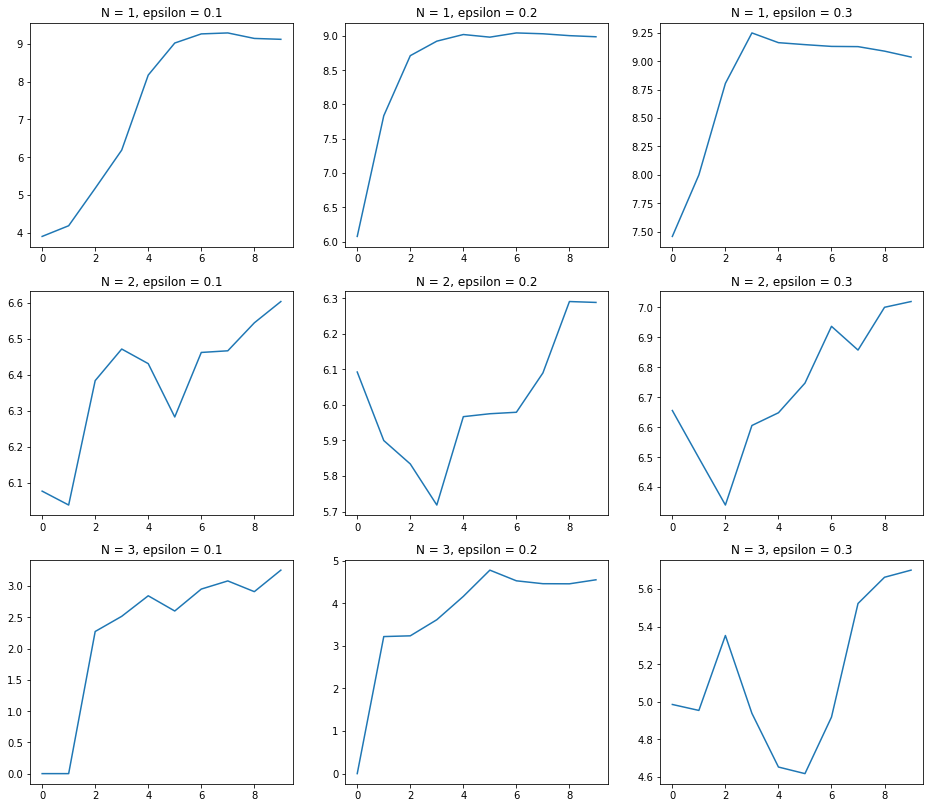

In [5]:
EPISODES = 200
env = TicTacToe()
configurations = [[1, 0.1], [1, 0.2], [1, 0.3], [2, 0.1], [2, 0.2], [2, 0.3], [3, 0.1], [3, 0.2], [3, 0.3]] # [[N, epsilon]]
plot_axes = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]

ln = list(range(0, 10))
figure, axis = plt.subplots(3, 3, figsize=(16, 14))

c = 0
for con in configurations:
  agent = N_Step_Q_Learning(env, N=con[0], epsilon=con[1])
  standard_error = []
  mean = []
  rewards = []
  for replication in range(10):
    for e in range(EPISODES):
      state = env.reset()
      reward = agent.train(state)
      if e % 5 == 0:
        rewards.append(reward)

    standard_error.append(statistics.stdev(rewards))
    mean.append(sum(rewards) / len(rewards))

  axis[plot_axes[c][0], plot_axes[c][1]].plot(ln, standard_error)
  #axis[plot_axes[c][0], plot_axes[c][1]].fill_between(ln, np.subtract(standard_error, mean), np.add(standard_error, mean), alpha=0.5)
  axis[plot_axes[c][0], plot_axes[c][1]].set_title("N = {0}, epsilon = {1}".format(con[0], con[1]))

  c += 1